# Music Genre Classification

CS760 2022S2 P13 Group

---

Install package for converting MP3 to CSV:

In [1]:
#!conda install -c conda-forge librosa

---

# 1. Package Import

In [2]:
import pandas as pd
import librosa
import random
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
random.seed(123)

---

# 2. Load Data

In [4]:
_30sec = pd.read_csv('Data/features_30_sec.csv')

---

# 3. Preprocessing

## 3.1 Load Data

Create features and labels sets, normalize the feature set, then perform PCA with 0.05 variance reduction. Finally convert to numpy matrix.

In [5]:
def preprocessing(data):
    X = data.iloc[:,19:59:2]
    y = data.iloc[:,-1]
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components = 0.95)
    X = pca.fit_transform(X)
    return X, y

In [6]:
X, y = preprocessing(_30sec)

In [7]:
np.unique(y)

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype=object)

## 3.2 MP3 TO CSV Function (Optional)

In [8]:
def mp3_to_df(filename):
    y,sr = librosa.load(filename)
    length = len(y)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_stft_mean = chroma_stft.mean()
    chroma_stft_var = chroma_stft.var()
    rms = librosa.feature.rms(y=y)
    rms_mean = rms.mean()
    rms_var = rms.var()
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_centroid_mean = spectral_centroid.mean()
    spectral_centroid_var = spectral_centroid.var()
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_bandwidth_mean = spectral_bandwidth.mean()
    spectral_bandwidth_var = spectral_bandwidth.var()
    rolloff = librosa.feature.spectral_rolloff(y=y,sr=sr)
    rolloff_mean = rolloff.mean()
    rolloff_var = rolloff.var()
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
    zero_crossing_rate_mean = zero_crossing_rate.mean()
    zero_crossing_rate_var = zero_crossing_rate.var()
    harmony = librosa.feature.tempogram(y=y, sr=sr)
    harmony_mean = harmony.mean()
    harmony_var = harmony.var()
    perceptr = librosa.effects.percussive(y=y)
    perceptr_mean = perceptr.mean()
    perceptr_var = perceptr.var()
    tempo = librosa.beat.tempo(y=y, sr=sr).mean()
    row = [[length,chroma_stft_mean,chroma_stft_var,
           rms_mean,rms_var,spectral_centroid_mean,
           spectral_centroid_var,spectral_bandwidth_mean,
           spectral_bandwidth_var,rolloff_mean,rolloff_var,
           zero_crossing_rate_mean,zero_crossing_rate_var,
           harmony_mean,harmony_var,perceptr_mean,
           perceptr_var,tempo]]
    df = pd.DataFrame(row, columns = 
                      ['length','chroma_stft_mean','chroma_stft_var',
                       'rms_mean','rms_var','spectral_centroid_mean',
                       'spectral_centroid_var','spectral_bandwidth_mean',
                       'spectral_bandwidth_var','rolloff_mean','rolloff_var',
                       'zero_crossing_rate_mean','zero_crossing_rate_var',
                       'harmony_mean','harmony_var','perceptr_mean',
                       'perceptr_var','tempo'])
    mfcc_arr = librosa.feature.mfcc(y=y, sr=sr)
    for i in range(len(mfcc_arr)):
        mean_colname = 'mfcc'+str(i+1)+'_mean'
        var_colname = 'mfcc'+str(i+1)+'_var'
        df[mean_colname] = mfcc_arr[i].mean()
        df[var_colname] = mfcc_arr[i].var()
    return df

## 3.3 View Groundtruth Clusters

In [9]:
X_og = _30sec.iloc[:,19:59:2]
X_t = StandardScaler().fit_transform(X_og)
X_2d = PCA(2).fit_transform(X_t)

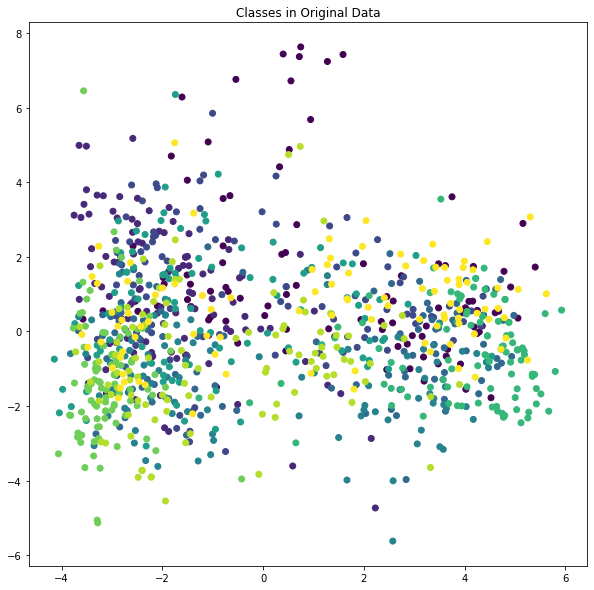

In [10]:
plt.figure(figsize=(10, 10))
plt.scatter(X_2d.T[0], X_2d.T[1], c=np.unique(y, return_inverse=True)[1], marker='o')
plt.title('Classes in Original Data')
plt.show()

---

# 4. Base Model

## 4.1 Fit base model

In [11]:
base = AgglomerativeClustering(n_clusters=10, linkage='ward', compute_distances=True).fit(X)

## 4.2 View base model

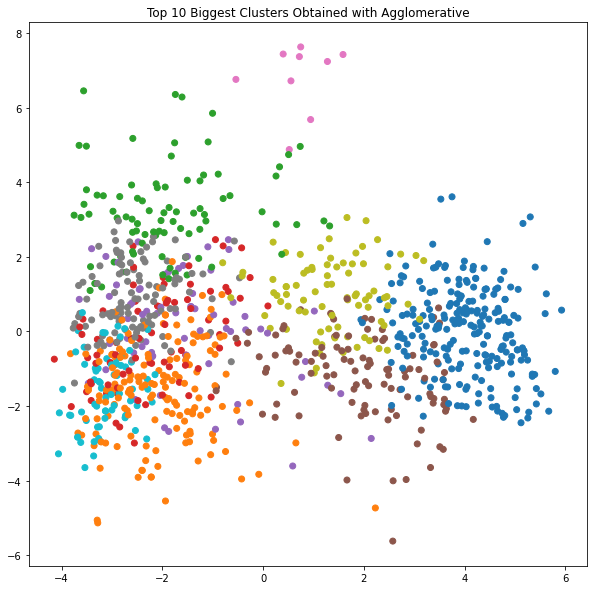

In [12]:
color = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.figure(figsize=(10, 10))
plt.scatter(X_2d.T[0], X_2d.T[1], c=base.labels_, cmap=color, marker='o')
plt.title('Top 10 Biggest Clusters Obtained with Agglomerative')
plt.show()

In [13]:
print(f'Adjusted random-index score for base model:\t{metrics.adjusted_rand_score(y,base.labels_)}')
print(f'Fowlkes-Mallows score for base model:\t{metrics.fowlkes_mallows_score(y,base.labels_)}')
print(f'Silhouette score for base model:\t{metrics.silhouette_score(X=X,labels=base.labels_,sample_size=800,random_state=123)}')
print(f'Davies-Bouldin score for base model:\t{metrics.davies_bouldin_score(X,base.labels_)}')

Adjusted random-index score for base model:	0.16623795285932585
Fowlkes-Mallows score for base model:	0.26287420991759797
Silhouette score for base model:	0.10786102533162517
Davies-Bouldin score for base model:	2.0331003299288746


Interpretation:<br>
Adjusted for chance, 17% of the clusters are assigned to the same groundtruth class.<br>
With confusion matrix, 26% of the clusters are similar to the groundtruth class.<br>
Silhouette score suggests that clusters are more likely to be overlapping than dense-seperation.<br>
The average similarity between clusters are 2, indicating very poor seperation.

Hence, we should continues to parameters tuning.

---

# 5. Extreme Value Theorem Optimization

## 5.1 Obtain optimal distance threshold

In [14]:
all_clusters = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=0, compute_distances=True).fit(X)

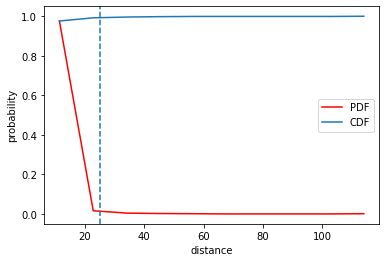

In [15]:
count, bins_count = np.histogram(all_clusters.distances_)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], pdf, color="red", label="PDF")
plt.plot(bins_count[1:], cdf, label="CDF")
plt.axvline(x=25, linestyle='dashed')
plt.xlabel('distance')
plt.ylabel('probability')
plt.legend()

I.e. clusters obtained with picking `distance_threshold = 23` should be the optimal setting.

## 5.2 EV optimised model fit:

In [16]:
ev_model = AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=25, compute_distances=True).fit(X)

In [17]:
ev_model.n_clusters_

7

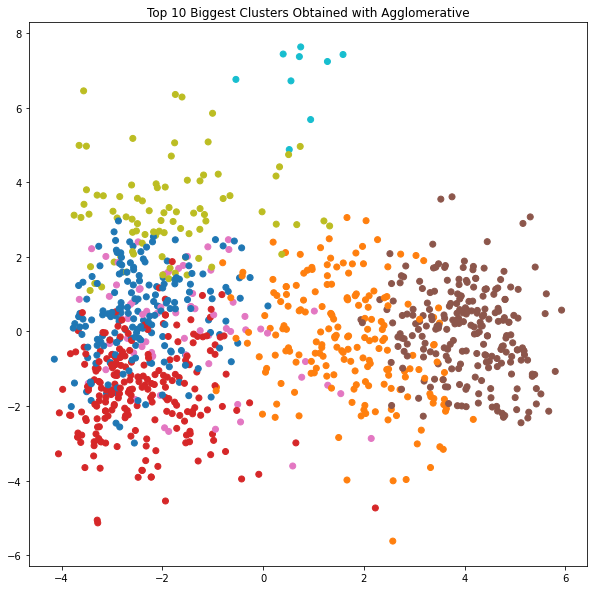

In [18]:
color = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.figure(figsize=(10, 10))
plt.scatter(X_2d.T[0], X_2d.T[1], c=ev_model.labels_, cmap=color, marker='o')
plt.title('Top 10 Biggest Clusters Obtained with Agglomerative')
plt.show()

In [19]:
print(f'Adjusted random-index score for EV model:\t{metrics.adjusted_rand_score(y,ev_model.labels_)}')
print(f'Fowlkes-Mallows score for EV model:\t{metrics.fowlkes_mallows_score(y,ev_model.labels_)}')
print(f'Silhouette score for EV model:\t{metrics.silhouette_score(X=X,labels=ev_model.labels_,sample_size=800,random_state=123)}')
print(f'Davies-Bouldin score for EV model:\t{metrics.davies_bouldin_score(X,ev_model.labels_)}')

Adjusted random-index score for EV model:	0.14178471028985506
Fowlkes-Mallows score for EV model:	0.26643927445056226
Silhouette score for EV model:	0.1356312612164174
Davies-Bouldin score for EV model:	1.9729354855524033


Slightly better seperation, with better similarity between groundtruth class and obtained clusters.

---

# 6. Grid Search

Max distance:

In [20]:
max(AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=23, compute_distances=True).fit(X).distances_)

114.0140215401505

## 6.1 `number_of_clusters` Search

In [21]:
n_clusters = []
ri_scores = []
fmi_scores = []
s_scores = []
db_scores = []
for nc in range(2,21):
    m = AgglomerativeClustering(n_clusters=nc, linkage='ward').fit(X)
    n_clusters.append(m.n_clusters_)
    ri_scores.append(metrics.adjusted_rand_score(y,m.labels_))
    fmi_scores.append(metrics.fowlkes_mallows_score(y,m.labels_))
    s_scores.append(metrics.silhouette_score(X=X,labels=m.labels_,sample_size=800,random_state=123))
    db_scores.append(metrics.davies_bouldin_score(X,m.labels_))

Text(0.5, 1.0, 'DB Score')

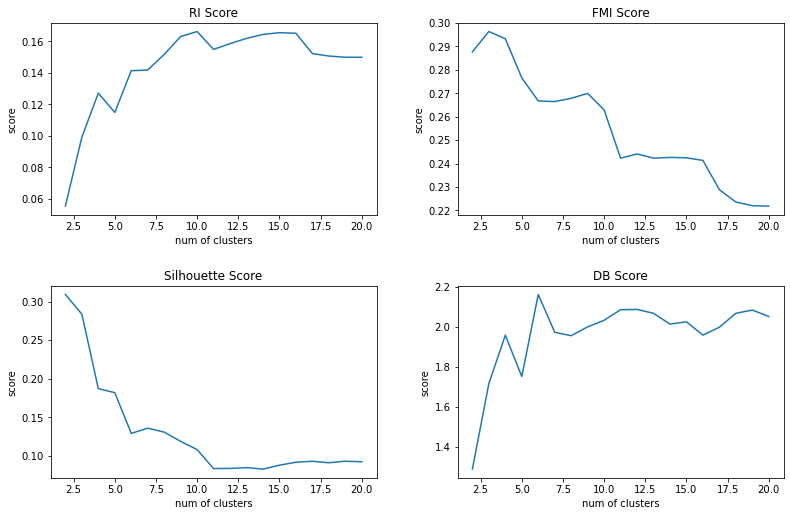

In [22]:
fig, ax = plt.subplots(2,2, figsize=(12, 8))
fig.tight_layout(pad=5)
ax[0,0].plot(n_clusters, ri_scores)
ax[0,0].set(xlabel='num of clusters', ylabel='score')
ax[0,0].set_title('RI Score')
ax[0,1].plot(n_clusters, fmi_scores)
ax[0,1].set(xlabel='num of clusters', ylabel='score')
ax[0,1].set_title('FMI Score')
ax[1,0].plot(n_clusters, s_scores)
ax[1,0].set(xlabel='num of clusters', ylabel='score')
ax[1,0].set_title('Silhouette Score')
ax[1,1].plot(n_clusters, db_scores)
ax[1,1].set(xlabel='num of clusters', ylabel='score')
ax[1,1].set_title('DB Score')

Except RI score, all other scoring metrics suggested that the lower number of clusters would be the best seperation. However, RI score suggested that either 10 or 15 clusters are the closest similarity to the groundtruth.

## 6.2 `distance_threshold` Search

In [23]:
thresholds = []
ri_scores = []
fmi_scores = []
s_scores = []
db_scores = []
for th in range(1,114):
    m = AgglomerativeClustering(n_clusters=None, distance_threshold=th, linkage='ward').fit(X)
    thresholds.append(th)
    ri_scores.append(metrics.adjusted_rand_score(y,m.labels_))
    fmi_scores.append(metrics.fowlkes_mallows_score(y,m.labels_))
    s_scores.append(metrics.silhouette_score(X=X,labels=m.labels_,sample_size=800,random_state=123))
    db_scores.append(metrics.davies_bouldin_score(X,m.labels_))

Text(0.5, 1.0, 'DB Score')

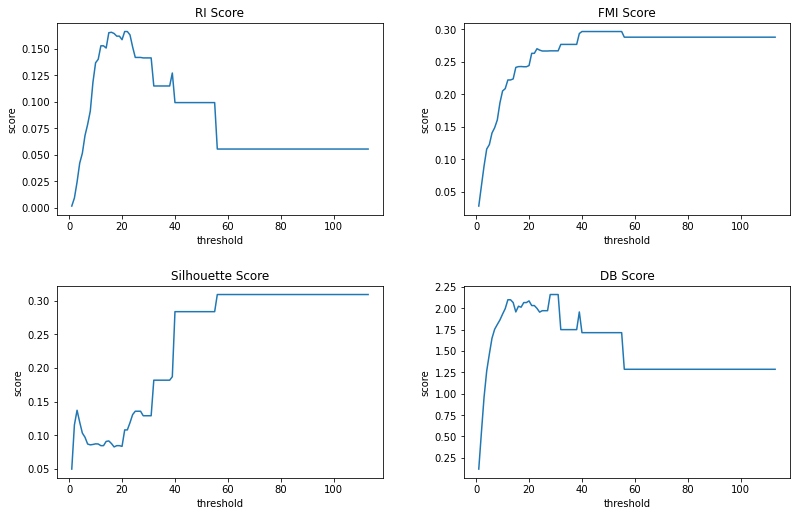

In [24]:
fig, ax = plt.subplots(2,2, figsize=(12, 8))
fig.tight_layout(pad=5)
ax[0,0].plot(thresholds, ri_scores)
ax[0,0].set(xlabel='threshold', ylabel='score')
ax[0,0].set_title('RI Score')
ax[0,1].plot(thresholds, fmi_scores)
ax[0,1].set(xlabel='threshold', ylabel='score')
ax[0,1].set_title('FMI Score')
ax[1,0].plot(thresholds, s_scores)
ax[1,0].set(xlabel='threshold', ylabel='score')
ax[1,0].set_title('Silhouette Score')
ax[1,1].plot(thresholds, db_scores)
ax[1,1].set(xlabel='threshold', ylabel='score')
ax[1,1].set_title('DB Score')

Except RI, all other scoring metrics suggest that setting the threshold high would show better seperation and better similarity to groundtruth class. However, RI suggests that setting the threshold to either 18 or 21 would have the optimal similarity to the groundtruth.

That is, if we want to have clusters that are more similar to the groundtruth classes, we set the threshold = 21, which in this case happens to be 10 clusters, i.e. the same number as the ground truth.

If solely based on internal information, to obtain the best seperation, we should set the threshold to as high as possible, i.e. as few clusters as possible, which indicates that our data is already very dense.<br>
Only obtaining 1 cluster means that we have done nothing in clssification, which is not what we want.

However, both Silhouette and DB score do suggest a second best local optimum, which is setting the number of clusters to 5 found with grid search, and 9 which is found with EV.

---

# 7. Model Exploratory Analysis

We have our 2 model, one with 10 clusters, and the other with 5 clusters, we can regard them as parent and child model, where the predicted labels are within the parent model:

In [25]:
parent_mod = AgglomerativeClustering(n_clusters=5, linkage='ward', compute_distances = True).fit(X)
child_mod = AgglomerativeClustering(n_clusters=9, linkage='ward', compute_distances = True).fit(X)

Function for obtaining the genre overlap distribution in each cluster:

In [26]:
def get_class_distribution(model, y):
    class_mtx = {}
    for i in range(len(y)):
        if model.labels_[i] not in class_mtx:
            class_mtx[model.labels_[i]] = []
            class_mtx[model.labels_[i]].append(y[i])
        else:
            class_mtx[model.labels_[i]].append(y[i])
    for k in class_mtx.copy().keys():
        freq_mtx = {}
        for i in class_mtx[k]:
            if i in freq_mtx:
                freq_mtx[i] += 1
            else:
                freq_mtx[i] = 1
        freq_mtx = dict(sorted(freq_mtx.items(), key=lambda item: item[1], reverse=True))
        class_mtx[k] = freq_mtx
    for i in class_mtx.keys():
        s = sum(class_mtx[i].values())
        for cl in class_mtx[i].keys():
            class_mtx[i][cl] = class_mtx[i][cl] / s
    return class_mtx

## 7.1 Dendrogram

Create function for dendrogram plotting:

In [27]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Plot dendrogram for the parent model:

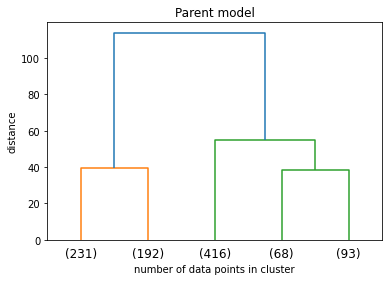

In [28]:
plt.title("Parent model")
plot_dendrogram(parent_mod, truncate_mode="lastp", p=5)
plt.xlabel("number of data points in cluster")
plt.ylabel("distance")
plt.show()

In [29]:
print(f'Random-index score for parent model:\t{metrics.rand_score(y,parent_mod.labels_)}')
print(f'Adjusted random-index score for parent model:\t{metrics.adjusted_rand_score(y,parent_mod.labels_)}')
print(f'Fowlkes-Mallows score for parent model:\t{metrics.fowlkes_mallows_score(y,parent_mod.labels_)}')
print(f'Silhouette score for parent model:\t{metrics.silhouette_score(X=X,labels=parent_mod.labels_,sample_size=800,random_state=123)}')
print(f'Davies-Bouldin score for parent model:\t{metrics.davies_bouldin_score(X,parent_mod.labels_)}')

Random-index score for parent model:	0.7165185185185186
Adjusted random-index score for parent model:	0.11483943511201125
Fowlkes-Mallows score for parent model:	0.2765579345278742
Silhouette score for parent model:	0.18178089800891506
Davies-Bouldin score for parent model:	1.7512195046619272


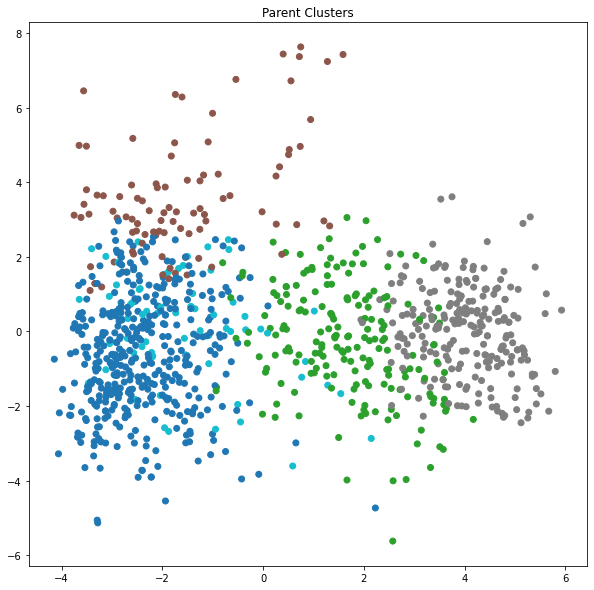

In [30]:
color = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.figure(figsize=(10, 10))
plt.scatter(X_2d.T[0], X_2d.T[1], c=parent_mod.labels_, cmap=color, marker='o')
plt.title('Parent Clusters')
plt.show()

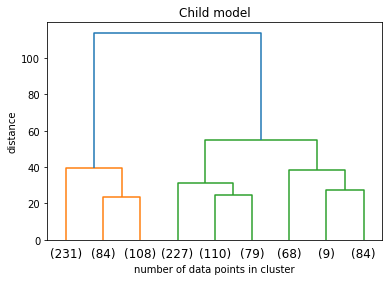

In [31]:
plt.title("Child model")
plot_dendrogram(child_mod, truncate_mode="lastp", p=9)
plt.xlabel("number of data points in cluster")
plt.ylabel("distance")
plt.show()

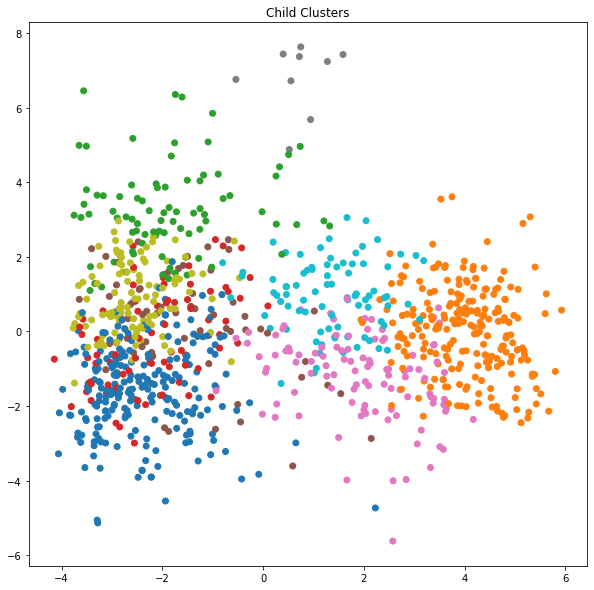

In [32]:
color = ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.figure(figsize=(10, 10))
plt.scatter(X_2d.T[0], X_2d.T[1], c=child_mod.labels_, cmap=color, marker='o')
plt.title('Child Clusters')
plt.show()

In [33]:
print(f'Random-index score for child model:\t{metrics.rand_score(y,child_mod.labels_)}')
print(f'Adjusted random-index score for child model:\t{metrics.adjusted_rand_score(y,child_mod.labels_)}')
print(f'Fowlkes-Mallows score for child model:\t{metrics.fowlkes_mallows_score(y,child_mod.labels_)}')
print(f'Silhouette score for child model:\t{metrics.silhouette_score(X=X,labels=child_mod.labels_,sample_size=800,random_state=123)}')
print(f'Davies-Bouldin score for child model:\t{metrics.davies_bouldin_score(X,child_mod.labels_)}')

Random-index score for child model:	0.8144824824824825
Adjusted random-index score for child model:	0.16307794903640174
Fowlkes-Mallows score for child model:	0.269931192073383
Silhouette score for child model:	0.11853939950177333
Davies-Bouldin score for child model:	1.9998664042542391


### Create function to convert int to percentage:

In [34]:
def prettify_dict(dct):
    new_dct = {}
    for clust in dct.keys():
        new_dct[clust] = {k:str(round(v*100,1))+'%' for k,v in dct[clust].items()}
    return new_dct

## 7.2 Child Clusters Exploratory

In [35]:
for i in range(0,1000,100):
    print(y[i])
    print(f'\tRI = \t{metrics.rand_score(y[i:i+100],child_mod.labels_[i:i+100])}')
    print(f'\tFMI = \t{metrics.fowlkes_mallows_score(y[i:i+100],child_mod.labels_[i:i+100])}')
    print(f'\tRI = \t{metrics.rand_score(y[i:i+100],child_mod.labels_[i:i+100])}')
    print(f'\tFMI = \t{metrics.fowlkes_mallows_score(y[i:i+100],child_mod.labels_[i:i+100])}')

blues
	RI = 	0.23232323232323232
	FMI = 	0.48199920365414745
	RI = 	0.23232323232323232
	FMI = 	0.48199920365414745
classical
	RI = 	0.4307070707070707
	FMI = 	0.6562827673397121
	RI = 	0.4307070707070707
	FMI = 	0.6562827673397121
country
	RI = 	0.15353535353535352
	FMI = 	0.39183587576350576
	RI = 	0.15353535353535352
	FMI = 	0.39183587576350576
disco
	RI = 	0.24404040404040403
	FMI = 	0.4940044575106626
	RI = 	0.24404040404040403
	FMI = 	0.4940044575106626
hiphop
	RI = 	0.30303030303030304
	FMI = 	0.5504818825631803
	RI = 	0.30303030303030304
	FMI = 	0.5504818825631803
jazz
	RI = 	0.1383838383838384
	FMI = 	0.3719997827739129
	RI = 	0.1383838383838384
	FMI = 	0.3719997827739129
metal
	RI = 	0.7775757575757576
	FMI = 	0.8818025615611227
	RI = 	0.7775757575757576
	FMI = 	0.8818025615611227
pop
	RI = 	0.6175757575757576
	FMI = 	0.7858598841878606
	RI = 	0.6175757575757576
	FMI = 	0.7858598841878606
reggae
	RI = 	0.21656565656565657
	FMI = 	0.4653661532230901
	RI = 	0.21656565656565657


In [36]:
genre_metric_dict = {}
for i in range(0,1000,100):
    ri = metrics.rand_score(y[i:i+100],child_mod.labels_[i:i+100])
    ari = metrics.adjusted_rand_score(y[i:i+100],child_mod.labels_[i:i+100])
    fmi = metrics.fowlkes_mallows_score(y[i:i+100],child_mod.labels_[i:i+100])
    genre_metric_dict[y[i]] = {'RI':ri, 'ARI':ari, 'FMI':fmi}

In [37]:
pd.DataFrame.from_dict(genre_metric_dict).T

,RI,ARI,FMI
blues,0.232323,0.0,0.481999
classical,0.430707,0.0,0.656283
country,0.153535,0.0,0.391836
disco,0.244040,0.0,0.494004
hiphop,0.303030,0.0,0.550482
jazz,0.138384,0.0,0.372000
metal,0.777576,0.0,0.881803
pop,0.617576,0.0,0.785860
reggae,0.216566,0.0,0.465366
rock,0.238788,0.0,0.488659


In [38]:
child_clusters = {}
for l in range(len(child_mod.labels_)):
    if child_mod.labels_[l] in child_clusters:
        child_clusters[child_mod.labels_[l]].append(l)
    else:
        child_clusters[child_mod.labels_[l]] = [l]

In [39]:
for k in child_clusters.keys():
    if k != 6:
        groundtruth_y = [y[i] for i in child_clusters[k]]
        groundtruth_x = [X[i] for i in child_clusters[k]]
        yhat = [k for i in range(len(child_clusters[k]))]
        print(f'Cluster {k}:')
        print(f'\t(external) RI = \t{metrics.rand_score(groundtruth_y, yhat)}')
        print(f'\t(external) FMI = \t{metrics.fowlkes_mallows_score(groundtruth_y, yhat)}')
        print(f'\t(internal) Sil = \t{metrics.silhouette_score(groundtruth_x, groundtruth_y)}')
        print(f'\t(internal) DB = \t{metrics.davies_bouldin_score(groundtruth_x, groundtruth_y)}')
    else:
        print(f'Cluster {k}:')
        print('\t(noise cluster)')

Cluster 5:
	(external) RI = 	0.18830044998269296
	(external) FMI = 	0.4339359975649554
	(internal) Sil = 	-0.03601907725728772
	(internal) DB = 	3.548226383353211
Cluster 8:
	(external) RI = 	0.1491681009753299
	(external) FMI = 	0.38622286438704
	(internal) Sil = 	-0.02247899258437441
	(internal) DB = 	3.1957432102731116
Cluster 3:
	(external) RI = 	0.1973385264524505
	(external) FMI = 	0.44422801178274485
	(internal) Sil = 	-0.05821451264477343
	(internal) DB = 	2.681524721606231
Cluster 2:
	(external) RI = 	0.2355134825014343
	(external) FMI = 	0.48529731351145383
	(internal) Sil = 	0.052598570709544094
	(internal) DB = 	2.2636384992727034
Cluster 6:
	(noise cluster)
Cluster 1:
	(external) RI = 	0.2287972896668549
	(external) FMI = 	0.47832759659761936
	(internal) Sil = 	-0.06747042499112231
	(internal) DB = 	3.3317347102868395
Cluster 0:
	(external) RI = 	0.19309188725585746
	(external) FMI = 	0.4394222198021596
	(internal) Sil = 	-0.014753300377861824
	(internal) DB = 	3.334179203

In [47]:
clust_metric_dict = {}
for k in child_clusters.keys():
    groundtruth_y = [y[i] for i in child_clusters[k]]
    groundtruth_x = [X[i] for i in child_clusters[k]]
    yhat = [k for i in range(len(child_clusters[k]))]
    ri = metrics.rand_score(groundtruth_y, yhat)
    ari = metrics.adjusted_rand_score(groundtruth_y, yhat)
    fmi = metrics.fowlkes_mallows_score(groundtruth_y, yhat)
    try:
        ss = metrics.silhouette_score(groundtruth_x, groundtruth_y)
        dbi = metrics.davies_bouldin_score(groundtruth_x, groundtruth_y)
    except:
        ss = None
        dbi = None
    clust_metric_dict[k] = {'RI':ri, 'ARI':ari, 'FMI':fmi, 'Silhouette':ss, 'DBI':dbi}

In [48]:
pd.DataFrame.from_dict(clust_metric_dict).T

,RI,ARI,FMI,Silhouette,DBI
5,0.188300,0.0,0.433936,-0.036019,3.548226
8,0.149168,0.0,0.386223,-0.022479,3.195743
3,0.197339,0.0,0.444228,-0.058215,2.681525
2,0.235513,0.0,0.485297,0.052599,2.263638
6,1.000000,1.0,1.000000,NaN,NaN
1,0.228797,0.0,0.478328,-0.067470,3.331735
0,0.193092,0.0,0.439422,-0.014753,3.334179
4,0.732221,0.0,0.855699,-0.136025,1.407548
7,0.137281,0.0,0.370515,-0.038411,4.596881


Reformat and showing only those overlapping genres with > 5% distribution:

In [49]:
for k,v in get_class_distribution(child_mod, y).items():
    if k != 6:
        print(f'Cluster ID {k}:')
        print({kk:str(round(vv*100,1))+'%' for kk,vv in v.items() if vv > 0.05})
        print()
    else:
        print(f'Cluster ID {k}:')
        print('(noise cluster)')
        print()

Cluster ID 5:
{'hiphop': '27.8%', 'reggae': '27.8%', 'disco': '13.0%', 'jazz': '12.0%', 'blues': '6.5%', 'country': '5.6%'}

Cluster ID 8:
{'country': '22.6%', 'rock': '22.6%', 'jazz': '16.7%', 'blues': '11.9%', 'metal': '7.1%', 'reggae': '7.1%'}

Cluster ID 3:
{'blues': '31.6%', 'jazz': '21.5%', 'reggae': '21.5%', 'country': '8.9%', 'pop': '6.3%'}

Cluster ID 2:
{'classical': '36.9%', 'country': '21.4%', 'jazz': '21.4%', 'blues': '11.9%'}

Cluster ID 6:
(noise cluster)

Cluster ID 1:
{'metal': '38.1%', 'rock': '16.9%', 'blues': '16.5%', 'disco': '16.0%', 'country': '6.1%'}

Cluster ID 0:
{'pop': '33.9%', 'hiphop': '19.8%', 'reggae': '13.2%', 'disco': '10.6%', 'rock': '7.9%', 'jazz': '6.2%', 'country': '5.7%'}

Cluster ID 4:
{'classical': '85.3%', 'jazz': '8.8%'}

Cluster ID 7:
{'country': '20.0%', 'disco': '17.3%', 'jazz': '14.5%', 'pop': '14.5%', 'rock': '13.6%', 'reggae': '9.1%', 'hiphop': '6.4%'}



In [50]:
pd.DataFrame.from_dict(prettify_dict(get_class_distribution(child_mod, y))).T

,hiphop,reggae,disco,jazz,blues,country,rock,metal,classical,pop
5,27.8%,27.8%,13.0%,12.0%,6.5%,5.6%,4.6%,2.8%,NaN,NaN
8,4.8%,7.1%,3.6%,16.7%,11.9%,22.6%,22.6%,7.1%,3.6%,NaN
3,3.8%,21.5%,2.5%,21.5%,31.6%,8.9%,2.5%,NaN,1.3%,6.3%
2,NaN,3.6%,NaN,21.4%,11.9%,21.4%,2.4%,NaN,36.9%,2.4%
6,NaN,NaN,NaN,NaN,100.0%,NaN,NaN,NaN,NaN,NaN
1,4.3%,1.3%,16.0%,0.9%,16.5%,6.1%,16.9%,38.1%,NaN,NaN
0,19.8%,13.2%,10.6%,6.2%,0.4%,5.7%,7.9%,1.3%,0.9%,33.9%
4,1.5%,1.5%,1.5%,8.8%,NaN,1.5%,NaN,NaN,85.3%,NaN
7,6.4%,9.1%,17.3%,14.5%,NaN,20.0%,13.6%,NaN,4.5%,14.5%


<AxesSubplot:>

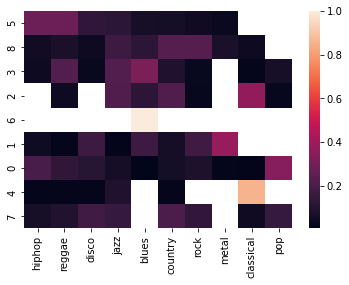

In [51]:
import seaborn as sns
sns.heatmap(pd.DataFrame.from_dict(get_class_distribution(child_mod, y)).transpose())

Above would be the found rules of overlapping.

## 7.3 Parent Clusters Exploratory

In [52]:
parent_clusters = {}
for l in range(len(parent_mod.labels_)):
    if parent_mod.labels_[l] in parent_clusters:
        parent_clusters[parent_mod.labels_[l]].append(l)
    else:
        parent_clusters[parent_mod.labels_[l]] = [l]

In [53]:
parent_child_list = {}
for par in parent_clusters.keys():
    child_list = []
    for par_ind in parent_clusters[par]:
        for child in child_clusters.keys():
            for ind in child_clusters[child]:
                if ind == par_ind:
                    child_str = 'child_clust-'+str(child)
                    if child_str not in child_list:
                        child_list.append(child_str)
    parent_child_list['parent_clust-'+str(par)] = child_list

In [54]:
{k:len(v) for k,v in parent_clusters.items()}

{1: 192, 0: 416, 2: 93, 3: 231, 4: 68}

In [55]:
{k:len(v) for k,v in child_clusters.items()}

{5: 108, 8: 84, 3: 79, 2: 84, 6: 9, 1: 231, 0: 227, 4: 68, 7: 110}

In [56]:
print('Hierachies of parent-child clusters:')
for par in parent_child_list.keys():
    print(par,':',sep='')
    print('\t',parent_child_list[par])
    print()

Hierachies of parent-child clusters:
parent_clust-1:
	 ['child_clust-5', 'child_clust-8']

parent_clust-0:
	 ['child_clust-3', 'child_clust-0', 'child_clust-7']

parent_clust-2:
	 ['child_clust-2', 'child_clust-6']

parent_clust-3:
	 ['child_clust-1']

parent_clust-4:
	 ['child_clust-4']



In [57]:
for k in parent_clusters.keys():
    groundtruth_y = [y[i] for i in parent_clusters[k]]
    groundtruth_x = [X[i] for i in parent_clusters[k]]
    yhat = [k for i in range(len(parent_clusters[k]))]
    print(f'Cluster {k}:')
    print(f'\t(external) RI = \t{metrics.rand_score(groundtruth_y, yhat)}')
    print(f'\t(external) FMI = \t{metrics.fowlkes_mallows_score(groundtruth_y, yhat)}')
    print(f'\t(internal) Sil = \t{metrics.silhouette_score(groundtruth_x, groundtruth_y)}')
    print(f'\t(internal) DB = \t{metrics.davies_bouldin_score(groundtruth_x, groundtruth_y)}')

Cluster 1:
	(external) RI = 	0.1324716404886562
	(external) FMI = 	0.36396653759467534
	(internal) Sil = 	0.0005031507127645404
	(internal) DB = 	3.9616045698061706
Cluster 0:
	(external) RI = 	0.13573911028730307
	(external) FMI = 	0.3684278902136795
	(internal) Sil = 	-0.02928326702241179
	(internal) DB = 	4.59055732335003
Cluster 2:
	(external) RI = 	0.22136512388966806
	(external) FMI = 	0.47049455245482713
	(internal) Sil = 	0.04379073883314328
	(internal) DB = 	2.1490890716841595
Cluster 3:
	(external) RI = 	0.2287972896668549
	(external) FMI = 	0.47832759659761936
	(internal) Sil = 	-0.06747042499112231
	(internal) DB = 	3.3317347102868395
Cluster 4:
	(external) RI = 	0.7322212467076383
	(external) FMI = 	0.8556992735229114
	(internal) Sil = 	-0.13602541695730475
	(internal) DB = 	1.4075475882555468


In [58]:
parent_clust_metric_dict = {}
for k in parent_clusters.keys():
    groundtruth_y = [y[i] for i in parent_clusters[k]]
    groundtruth_x = [X[i] for i in parent_clusters[k]]
    yhat = [k for i in range(len(parent_clusters[k]))]
    ri = metrics.rand_score(groundtruth_y, yhat)
    ari = metrics.adjusted_rand_score(groundtruth_y, yhat)
    fmi = metrics.fowlkes_mallows_score(groundtruth_y, yhat)
    try:
        ss = metrics.silhouette_score(groundtruth_x, groundtruth_y)
        dbi = metrics.davies_bouldin_score(groundtruth_x, groundtruth_y)
    except:
        ss = None
        dbi = None
    parent_clust_metric_dict[k] = {'RI':ri, 'ARI':ari, 'FMI':fmi, 'Silhouette':ss, 'DBI':dbi}

In [59]:
pd.DataFrame.from_dict(parent_clust_metric_dict).T

,RI,ARI,FMI,Silhouette,DBI
1,0.132472,0.0,0.363967,0.000503,3.961605
0,0.135739,0.0,0.368428,-0.029283,4.590557
2,0.221365,0.0,0.470495,0.043791,2.149089
3,0.228797,0.0,0.478328,-0.067470,3.331735
4,0.732221,0.0,0.855699,-0.136025,1.407548


In [60]:
for k,v in get_class_distribution(parent_mod, y).items():
    print(f'Cluster ID {k}:')
    print({kk:str(round(vv*100,1))+'%' for kk,vv in v.items() if vv > 0.05})
    print()

Cluster ID 1:
{'reggae': '18.8%', 'hiphop': '17.7%', 'jazz': '14.1%', 'country': '13.0%', 'rock': '12.5%', 'blues': '8.9%', 'disco': '8.9%'}

Cluster ID 0:
{'pop': '23.6%', 'reggae': '13.7%', 'hiphop': '13.2%', 'jazz': '11.3%', 'disco': '10.8%', 'country': '10.1%', 'rock': '8.4%', 'blues': '6.2%'}

Cluster ID 2:
{'classical': '33.3%', 'blues': '20.4%', 'country': '19.4%', 'jazz': '19.4%'}

Cluster ID 3:
{'metal': '38.1%', 'rock': '16.9%', 'blues': '16.5%', 'disco': '16.0%', 'country': '6.1%'}

Cluster ID 4:
{'classical': '85.3%', 'jazz': '8.8%'}



In [61]:
pd.DataFrame.from_dict(prettify_dict(get_class_distribution(parent_mod, y))).transpose()

,reggae,hiphop,jazz,country,rock,blues,disco,metal,classical,pop
1,18.8%,17.7%,14.1%,13.0%,12.5%,8.9%,8.9%,4.7%,1.6%,NaN
0,13.7%,13.2%,11.3%,10.1%,8.4%,6.2%,10.8%,0.7%,1.9%,23.6%
2,3.2%,NaN,19.4%,19.4%,2.2%,20.4%,NaN,NaN,33.3%,2.2%
3,1.3%,4.3%,0.9%,6.1%,16.9%,16.5%,16.0%,38.1%,NaN,NaN
4,1.5%,1.5%,8.8%,1.5%,NaN,NaN,1.5%,NaN,85.3%,NaN


<AxesSubplot:>

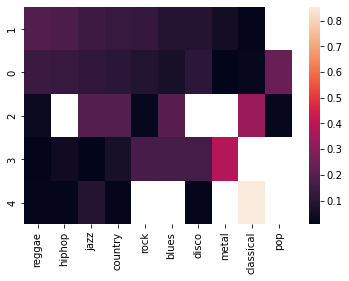

In [62]:
import seaborn as sns
sns.heatmap(pd.DataFrame.from_dict(get_class_distribution(parent_mod, y)).transpose())